# Imports

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

from torchvision import models
from torchvision import transforms

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
device = "cpu"

In [3]:
# Model
fcn_model = models.segmentation.fcn_resnet50(pretrained=True).to(device).eval()

# Input preprocessing transformation
preprocessing = transforms.Compose([transforms.Resize(640), 
                                    transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# This method allows us to visualize a particular segmentation output, by setting
# each pixels color according to the given segmentation class provided in the 
# image (segmentation output).
def decode_segmap(image, nc=21):  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [5]:
# Get a image from the dataset
!wget -nv --directory-prefix=img/segmentation/ https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg

2023-08-23 19:31:12 URL:https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg [110427] -> "img/segmentation/8862358875_eecba9fb10_z.jpg.1" [1]


/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/li

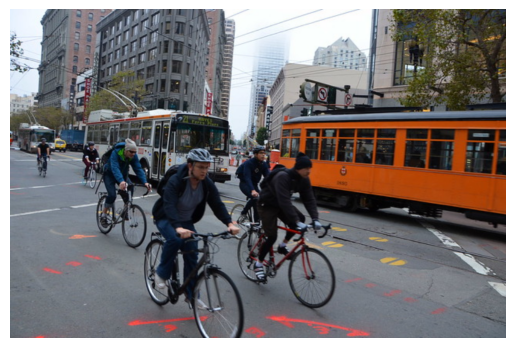

In [6]:
# %matplotlib inline
img = Image.open("img/segmentation/8862358875_eecba9fb10_z.jpg")
preproc_img = preprocessing(img)
_ = plt.imshow(preproc_img.permute(1,2,0)); plt.axis('off')
_ = plt.show()

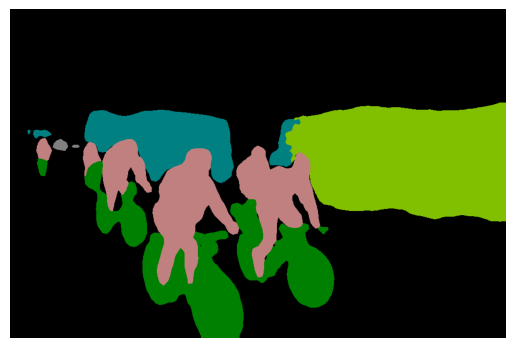

In [7]:
# Normalize image and compute segmentation output
normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
normalized_inp.requires_grad = True
out = fcn_model(normalized_inp)['out']

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
_ = plt.imshow(rgb); plt.axis('off'); plt.show()

In [8]:
"""
This wrapper computes the segmentation model output and sums the pixel scores for
all pixels predicted as each class, returning a tensor with a single value for
each class. This makes it easier to attribute with respect to a single output
scalar, as opposed to an individual pixel output attribution.
"""
""" def agg_segmentation_wrapper(inp):
    model_out = fcn(inp)['out']
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3)) 


# Alternate wrapper, simply summing each output channel
def wrapper(inp):
   return fcn(inp)['out'].sum(dim=(2,3)) """

def wrapper_pix(inp):
    model_out = fcn_model(inp)['out']
    return (model_out[0:1, :, 263, 705])

#TODO: change little regions of image to check effect on influence maps
def wrapper_region(inp):
    model_out = fcn_model(inp)['out']
    return (model_out[0:1, :, 3:6,4:7]).sum(dim=(2,3))

In [9]:
#TODO: check GradCam article about the summation of channels, if theres a discussion about differents influences of channels
#TODO: check 5 most relevant(bigger means) maps changing the pixels and the targets, for each line a different target/pixel
#TODO: given a pixel see how its influence image/region is generate

In [10]:
# Gradcam for layers
layer_gradcam = LayerGradCam(wrapper_pix, fcn_model.backbone.layer4[2].conv3)

In [11]:
gradcam_attr = layer_gradcam.attribute(normalized_inp, 
                                  target=19, 
                                  attr_dim_summation=True)
gradcam_attr.shape

torch.Size([1, 1, 80, 121])

In [25]:
gradcam_attr_false = layer_gradcam.attribute(normalized_inp, 
                                             target=19, attr_dim_summation=False)
gradcam_attr_false.shape

torch.Size([1, 2048, 80, 121])

In [13]:
gradcam_attr_false_dettached = gradcam_attr_false.detach().cpu()

# Sum of channels = same as attr_dim_summation=True
sum_maps = gradcam_attr_false_dettached.sum(dim=1)

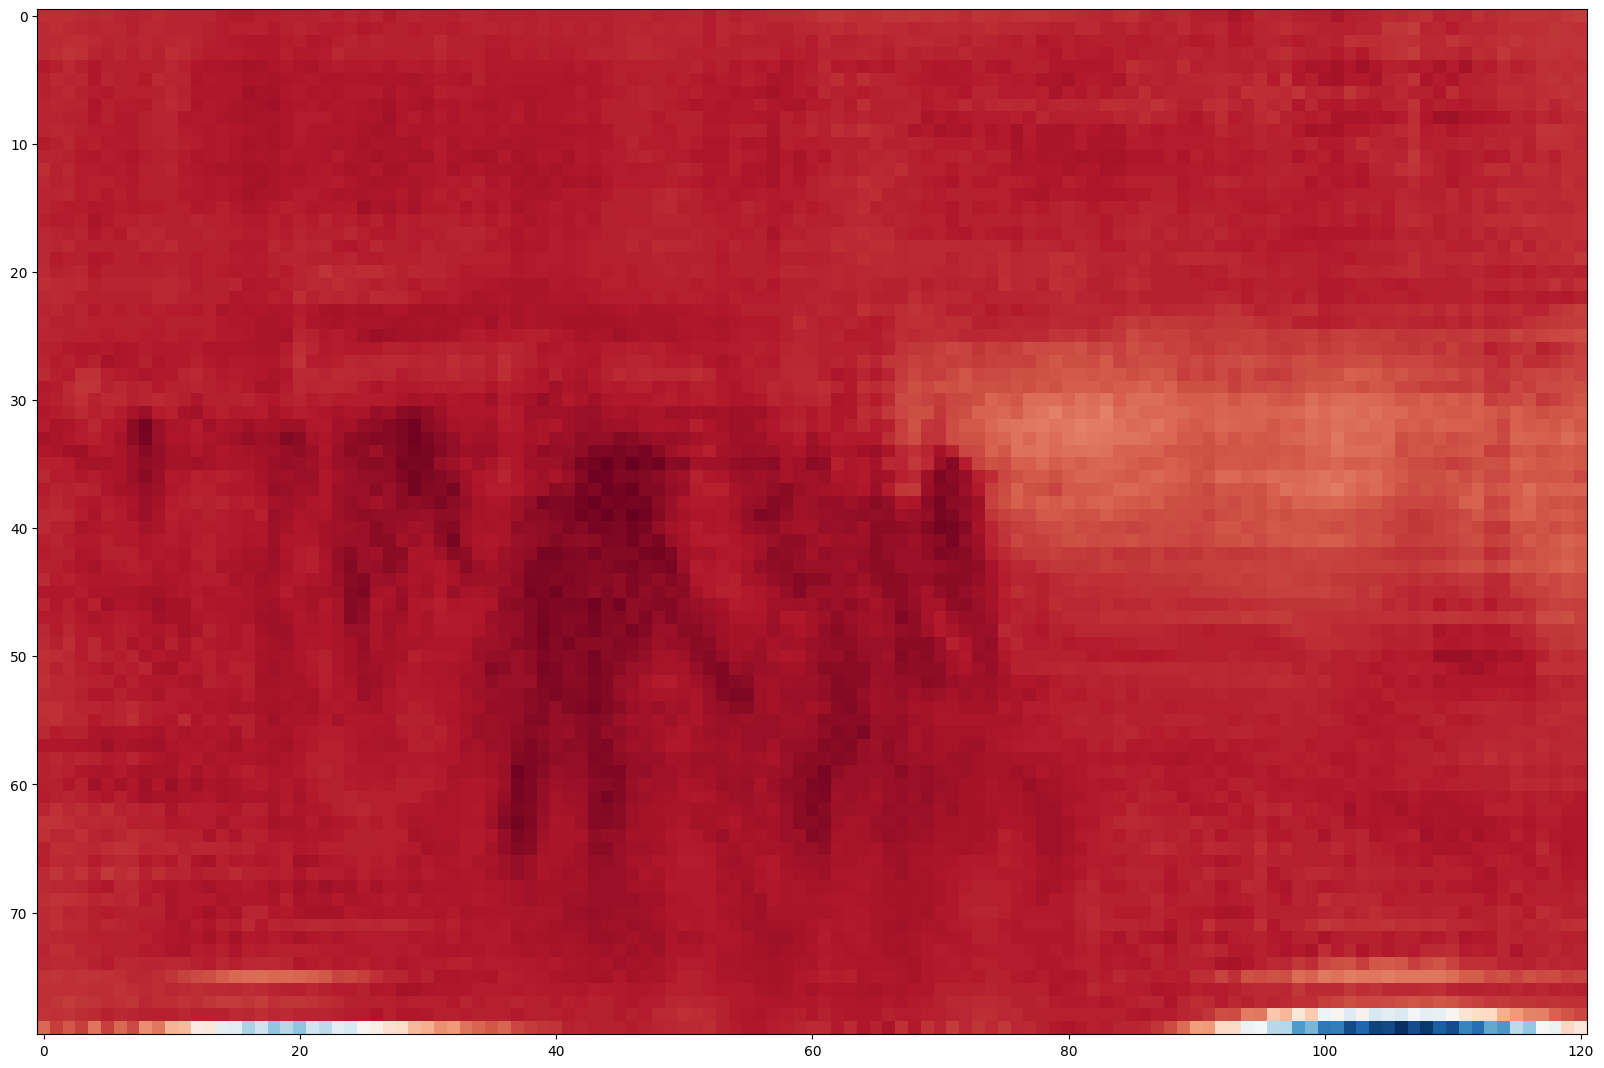

In [14]:
#TODO: try to increase positive region to check effect on influnce
sum_maps
plt.figure(figsize=[20,20])
_ = plt.imshow(sum_maps[0].numpy(), 
                 cmap='RdBu')

In [15]:
layer_activation = LayerActivation(wrapper_pix, 
                                   fcn_model.backbone.layer4[2].conv3)

activation = layer_activation.attribute(normalized_inp)
print("Input Shape:", normalized_inp.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gradcam_attr_false_dettached.shape)

Input Shape: torch.Size([1, 3, 640, 966])
Layer Activation Shape: torch.Size([1, 2048, 80, 121])
Layer GradCAM Shape: torch.Size([1, 2048, 80, 121])


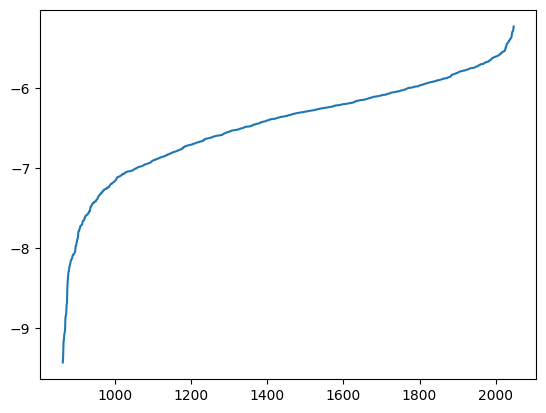

In [16]:
avrg_maps = gradcam_attr_false_dettached.abs().mean(dim=(2,3))[0]
log_avrg_maps = torch.log10(avrg_maps).numpy()
_ = plt.plot(sorted(log_avrg_maps))

torch.Size([2048])


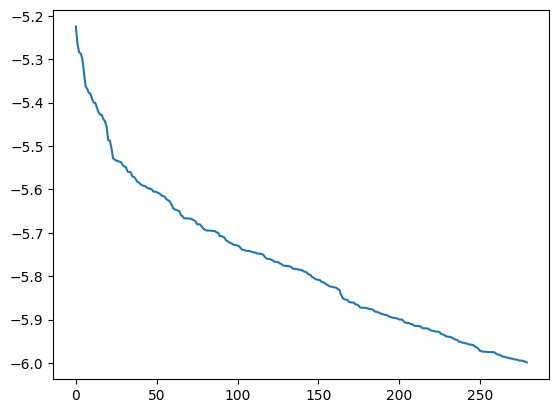

In [17]:
#TODO: check non zero maps on gc_attr.abs().mean(dim=(2,3))[0].detach().numpy()), >1e-6
threshold = -6

heat_maps = gradcam_attr_false_dettached
avrg_array = heat_maps.abs().mean(dim=(2,3))[0]
print(avrg_array.shape)
idx = torch.argsort(avrg_array, descending=True)
# Return the sorted array
sorted_array = avrg_array[idx]

maps = torch.log10(sorted_array).numpy()

filtered_maps = [map for map in maps if map > threshold]
filtered_maps
_ = plt.plot(filtered_maps)

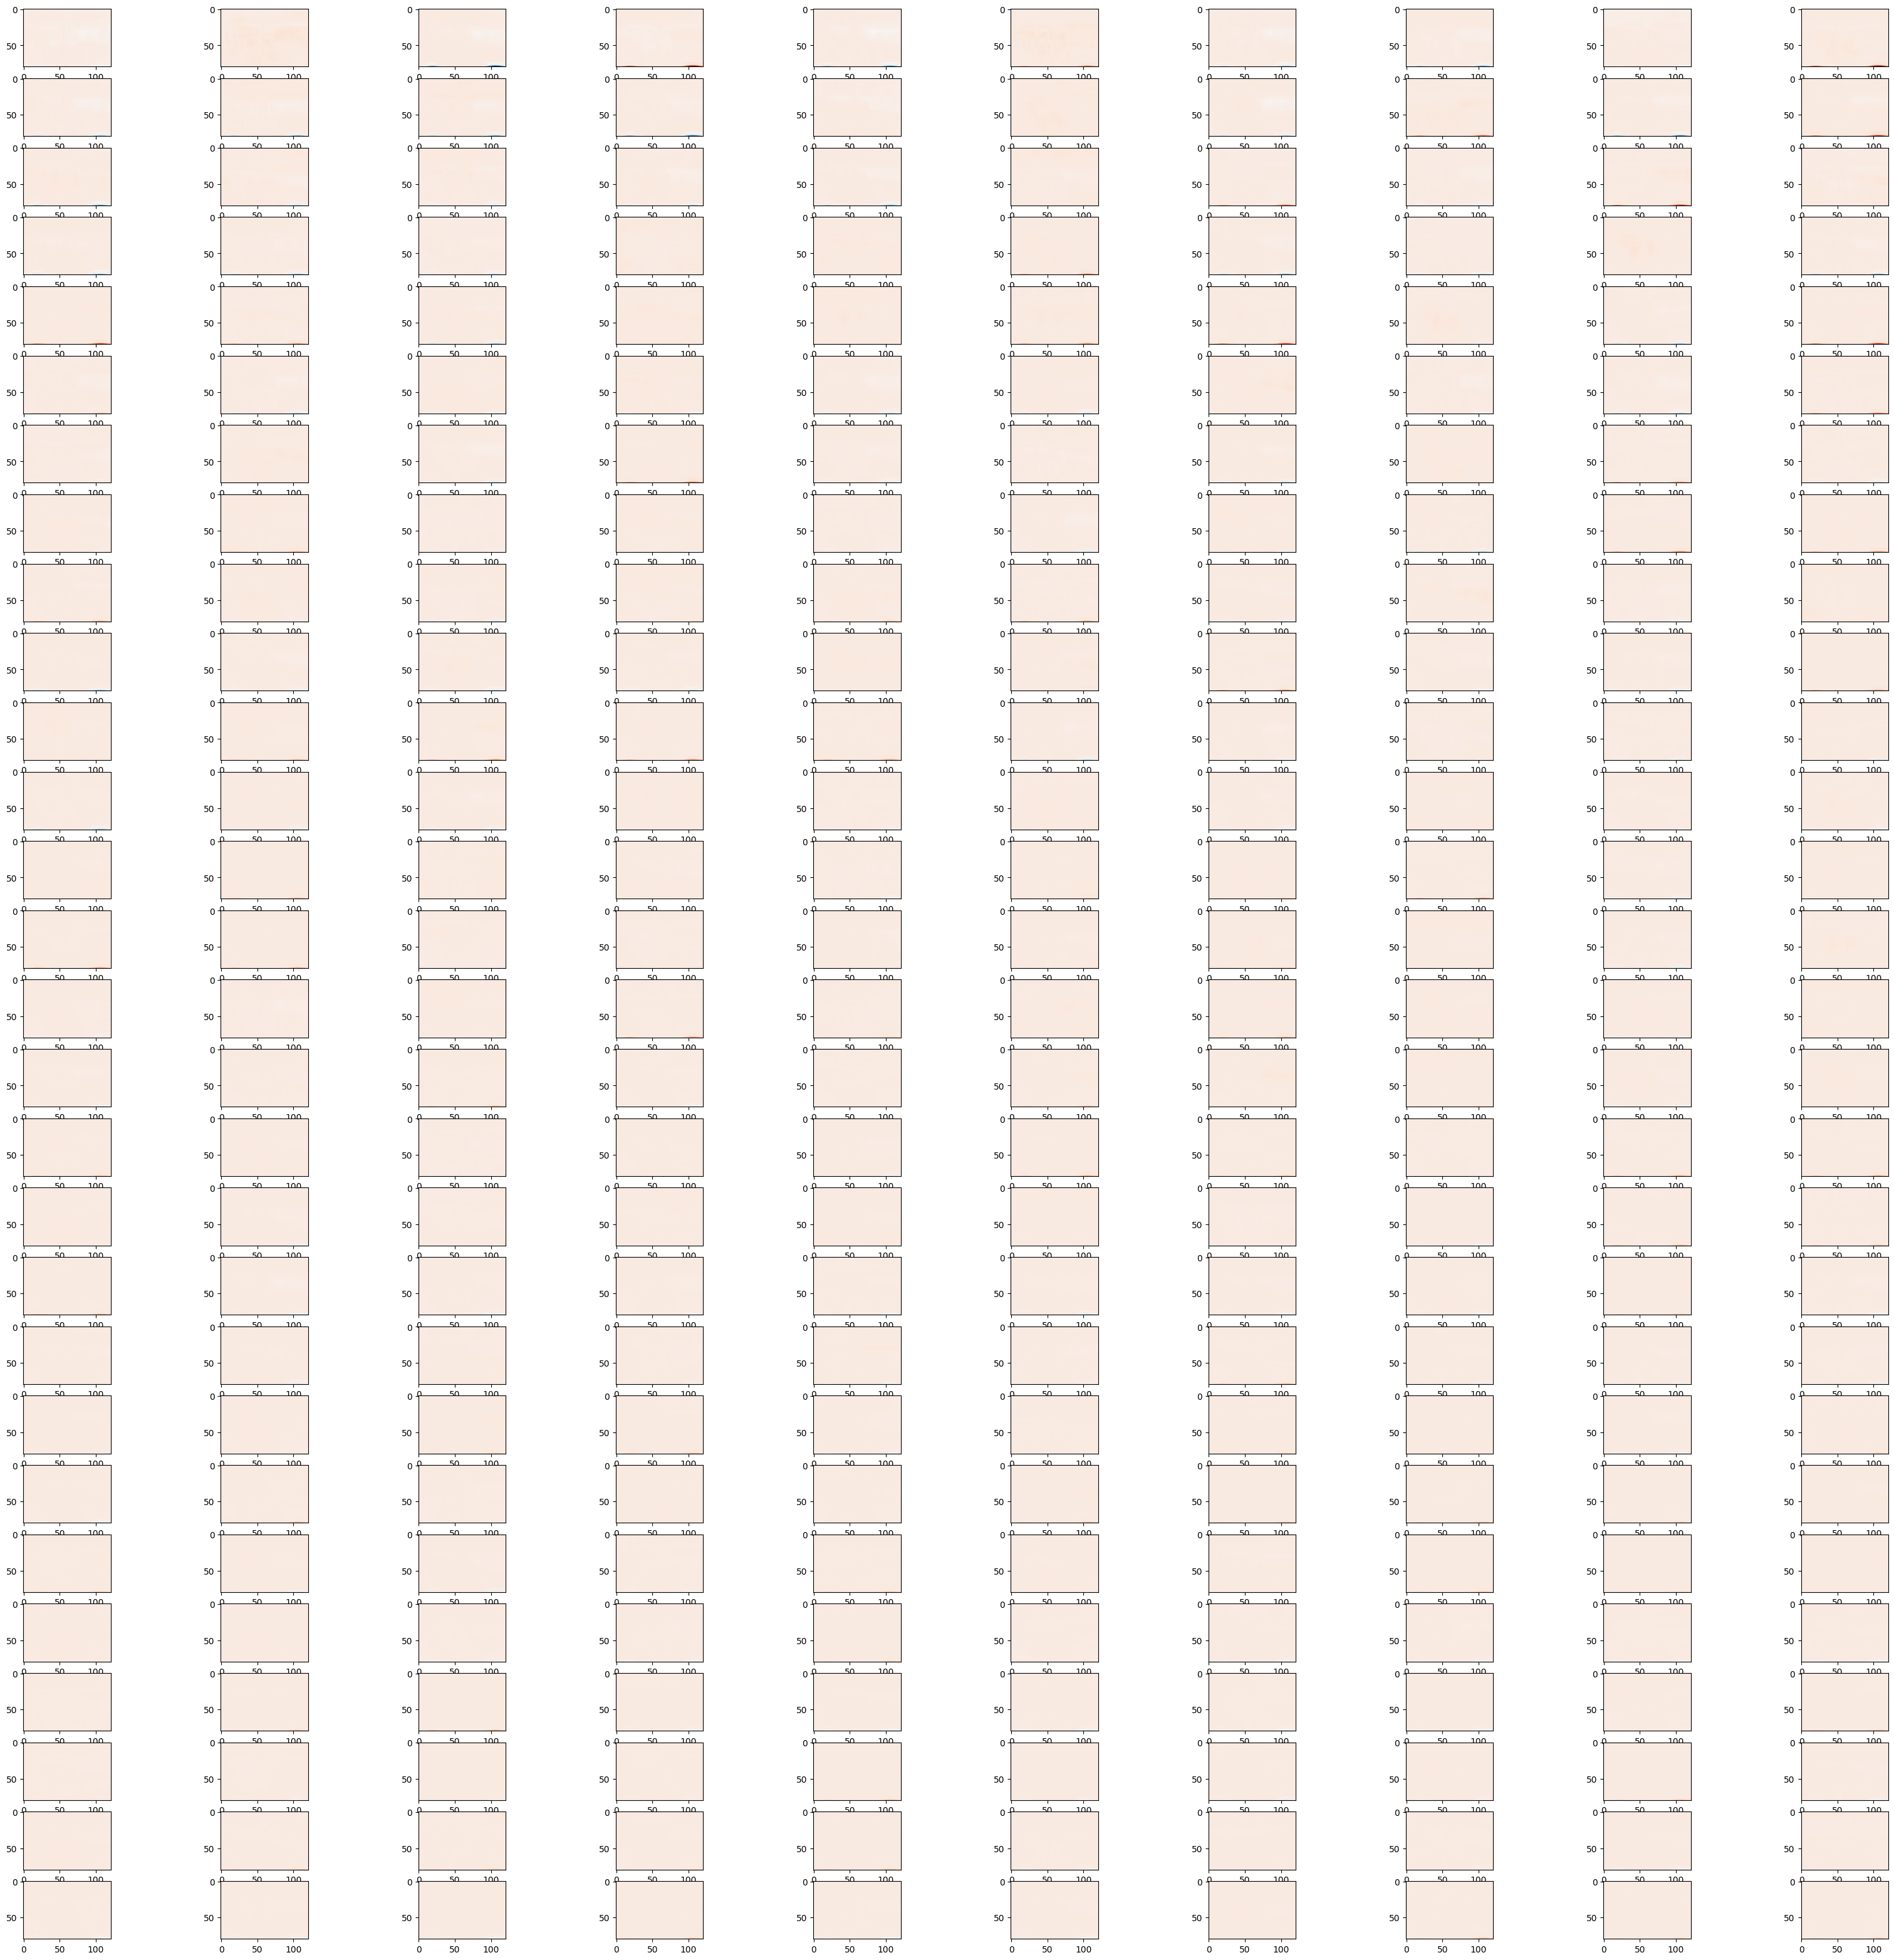

In [18]:
#TODO: check non zero maps on gc_attr.abs().mean(dim=(2,3))[0].detach().numpy()), >1e-6
idx_maps = torch.log10(gradcam_attr_false_dettached.abs().mean(dim=(2,3))[0])

""" condition = idx_maps > threshold
indices = torch.nonzero(condition).squeeze()
 """
min = heat_maps.min()
max = heat_maps.max()

plt.figure(figsize=[40,40])
for i in range(280):
  plt.subplot(28,10, i + 1)
  _ = plt.imshow(gradcam_attr_false_dettached[0, idx[i]].numpy(), 
                 cmap='RdBu', 
                 vmax=max, 
                 vmin=min)

tensor(-5.2248)

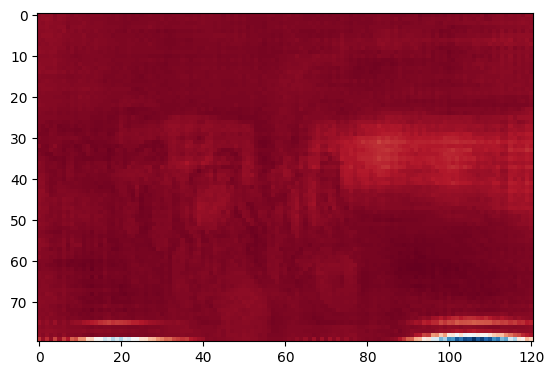

In [19]:
_ = plt.imshow(gradcam_attr_false_dettached[0, idx[6]].numpy(), cmap='RdBu')
torch.log10(gradcam_attr_false_dettached[0, idx[0]].abs().mean())

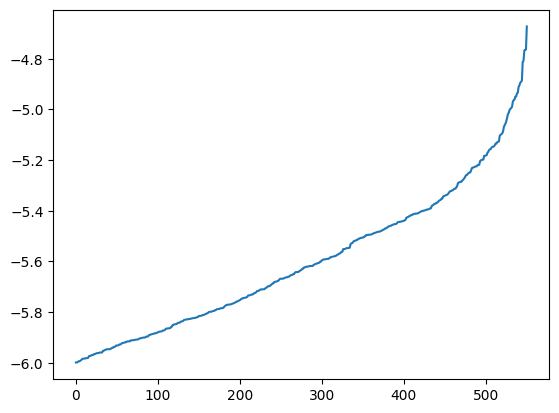

In [20]:
#TODO: check max values, try plot std
threshold = -6
maps = sorted(torch.log10(gradcam_attr_false_dettached.abs().std(dim=(2,3))[0]).numpy())

filtered_maps = [map for map in maps if map > threshold]
filtered_maps
_ = plt.plot(filtered_maps)

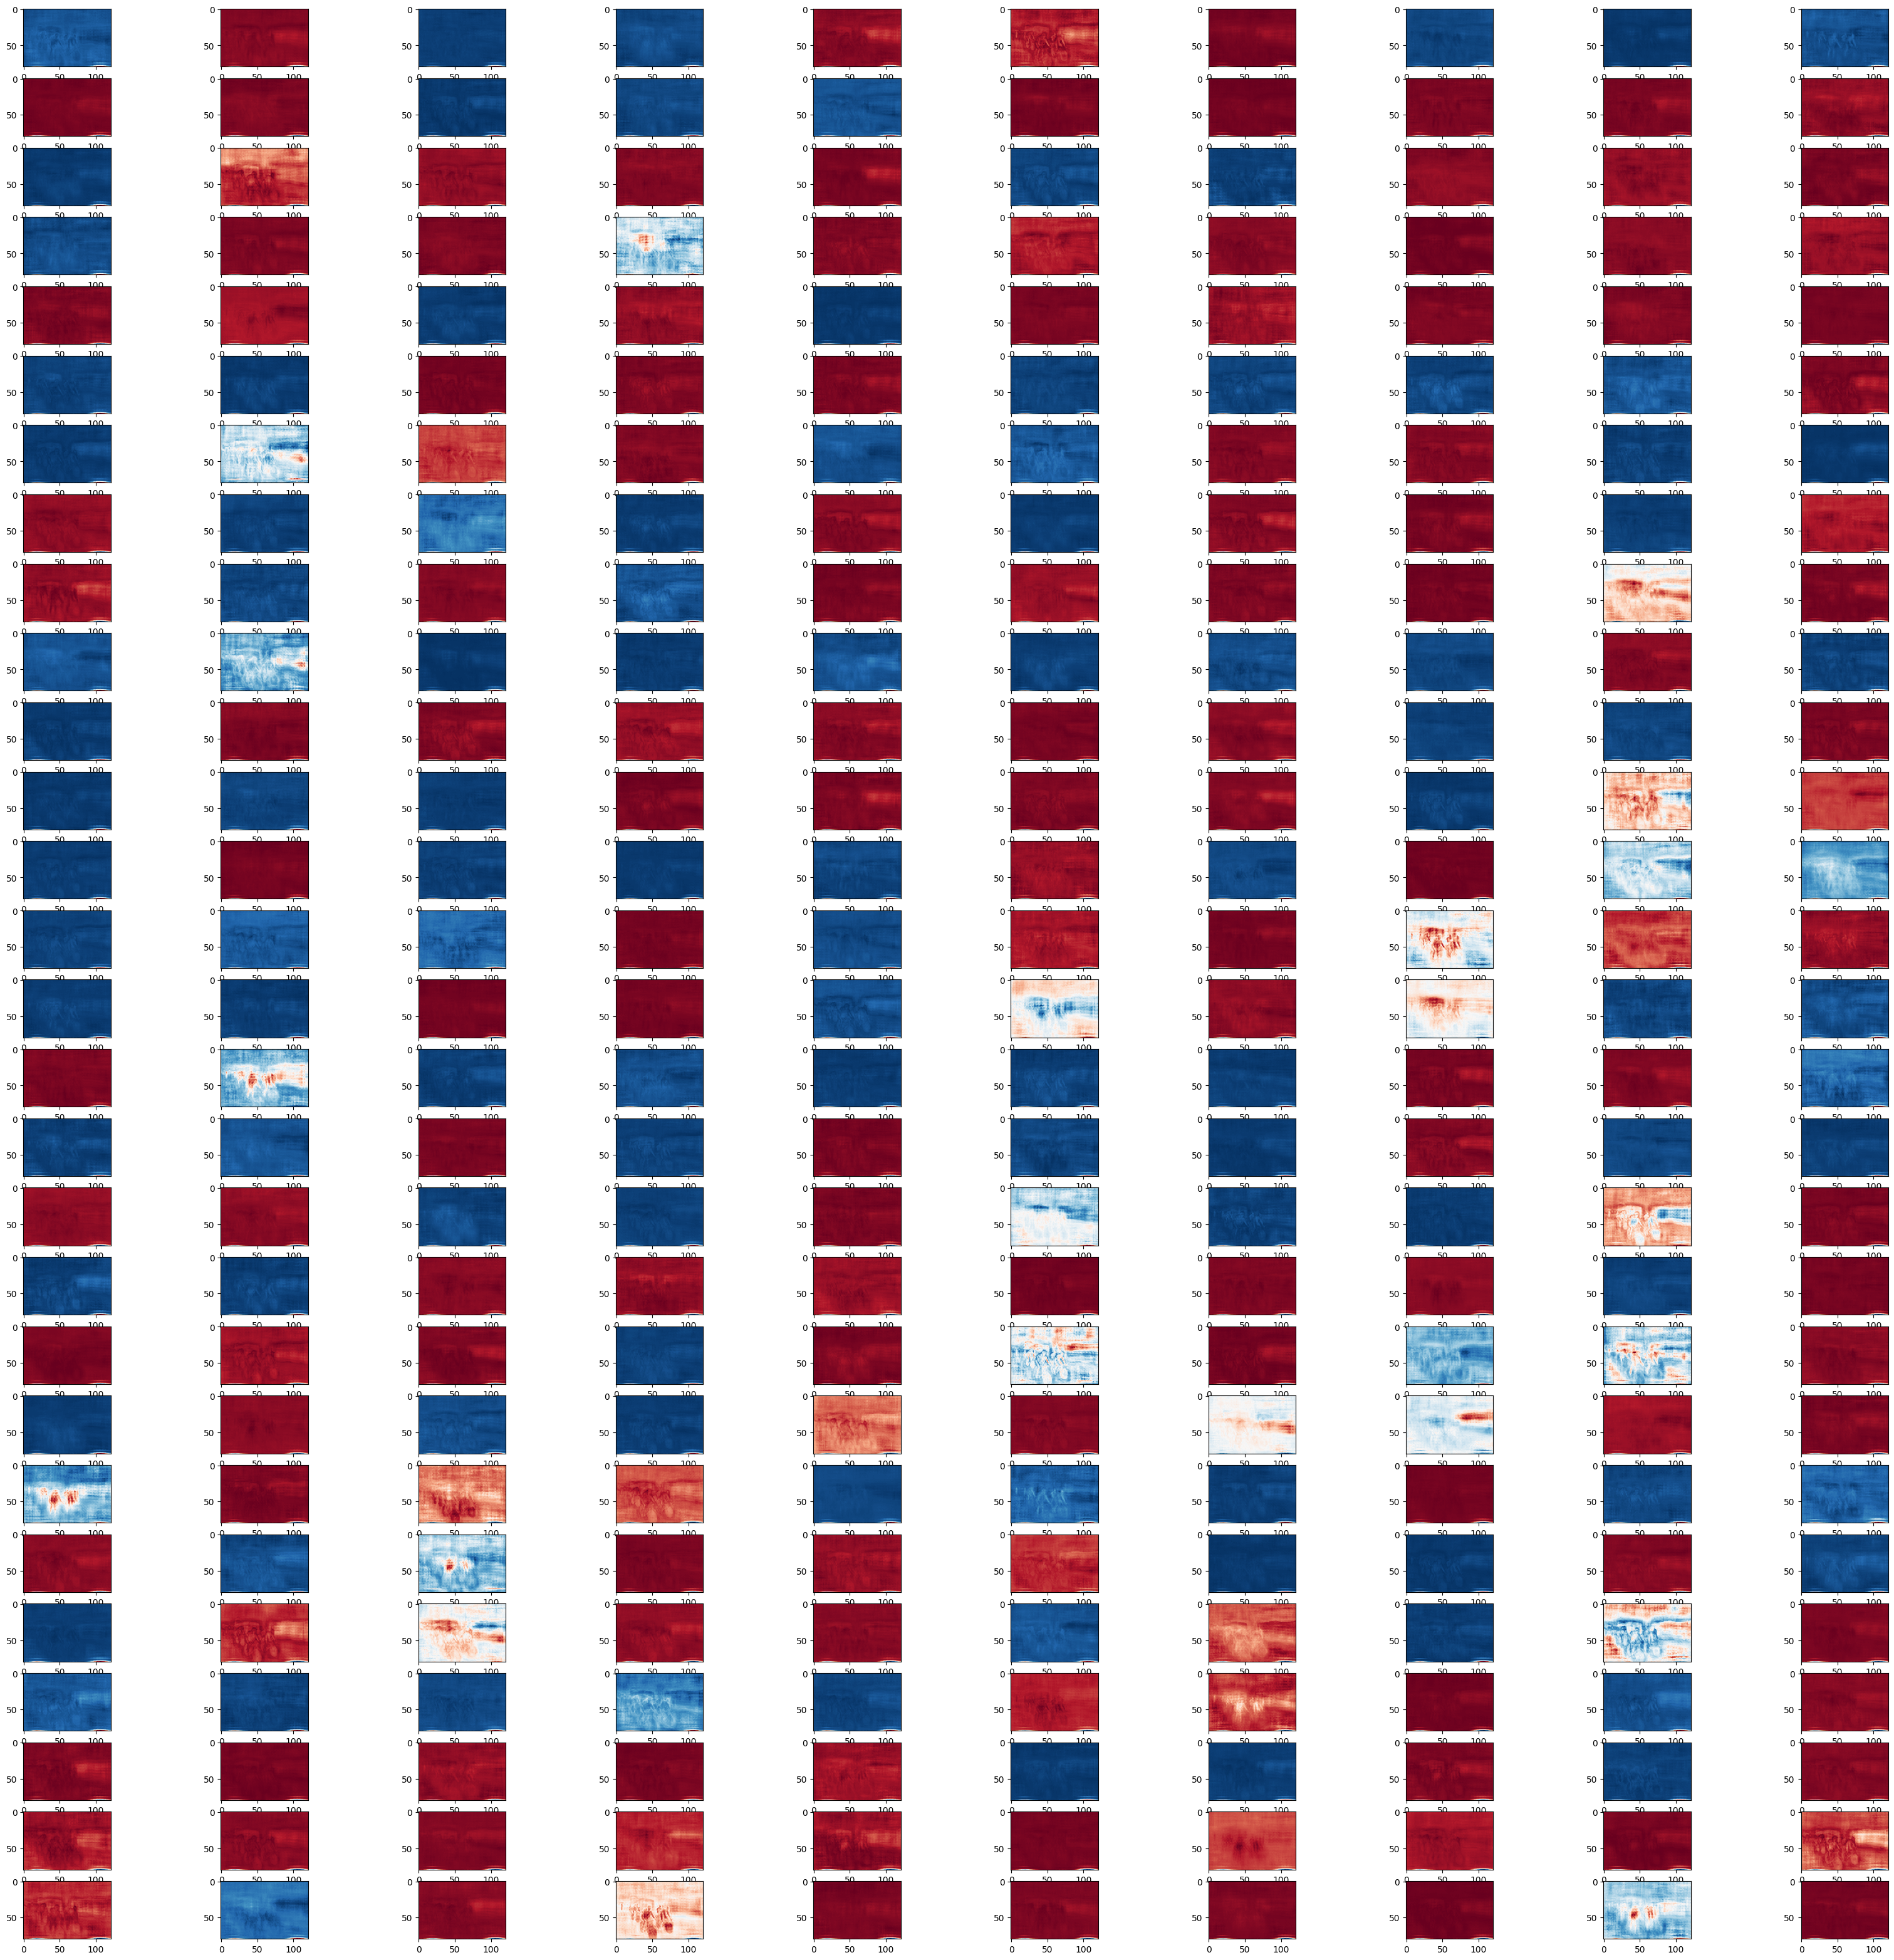

In [21]:
idx_maps = torch.log10(gradcam_attr_false_dettached.abs().std(dim=(2,3))[0])

#TODO: show maps on decrecent order
condition = idx_maps > threshold
indices = torch.nonzero(condition).squeeze()

plt.figure(figsize=[40,40])
for i in range(280):
  plt.subplot(28,10, i + 1)
  _ = plt.imshow(gradcam_attr_false_dettached[0, indices[i]].numpy(), cmap='RdBu')

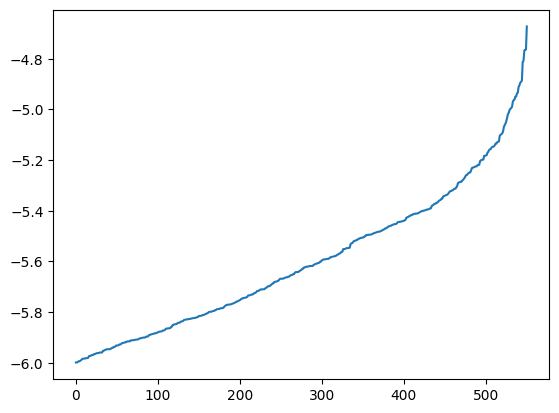

In [22]:
#TODO: check max values, try plot std
threshold = -6
max_values  = sorted(torch.log10(gradcam_attr_false_dettached[0:1, :, :, :][0].abs().max(dim=0).values).numpy().flatten())

filtered_maps = [map for map in maps if map > threshold]
filtered_maps
_ = plt.plot(filtered_maps)

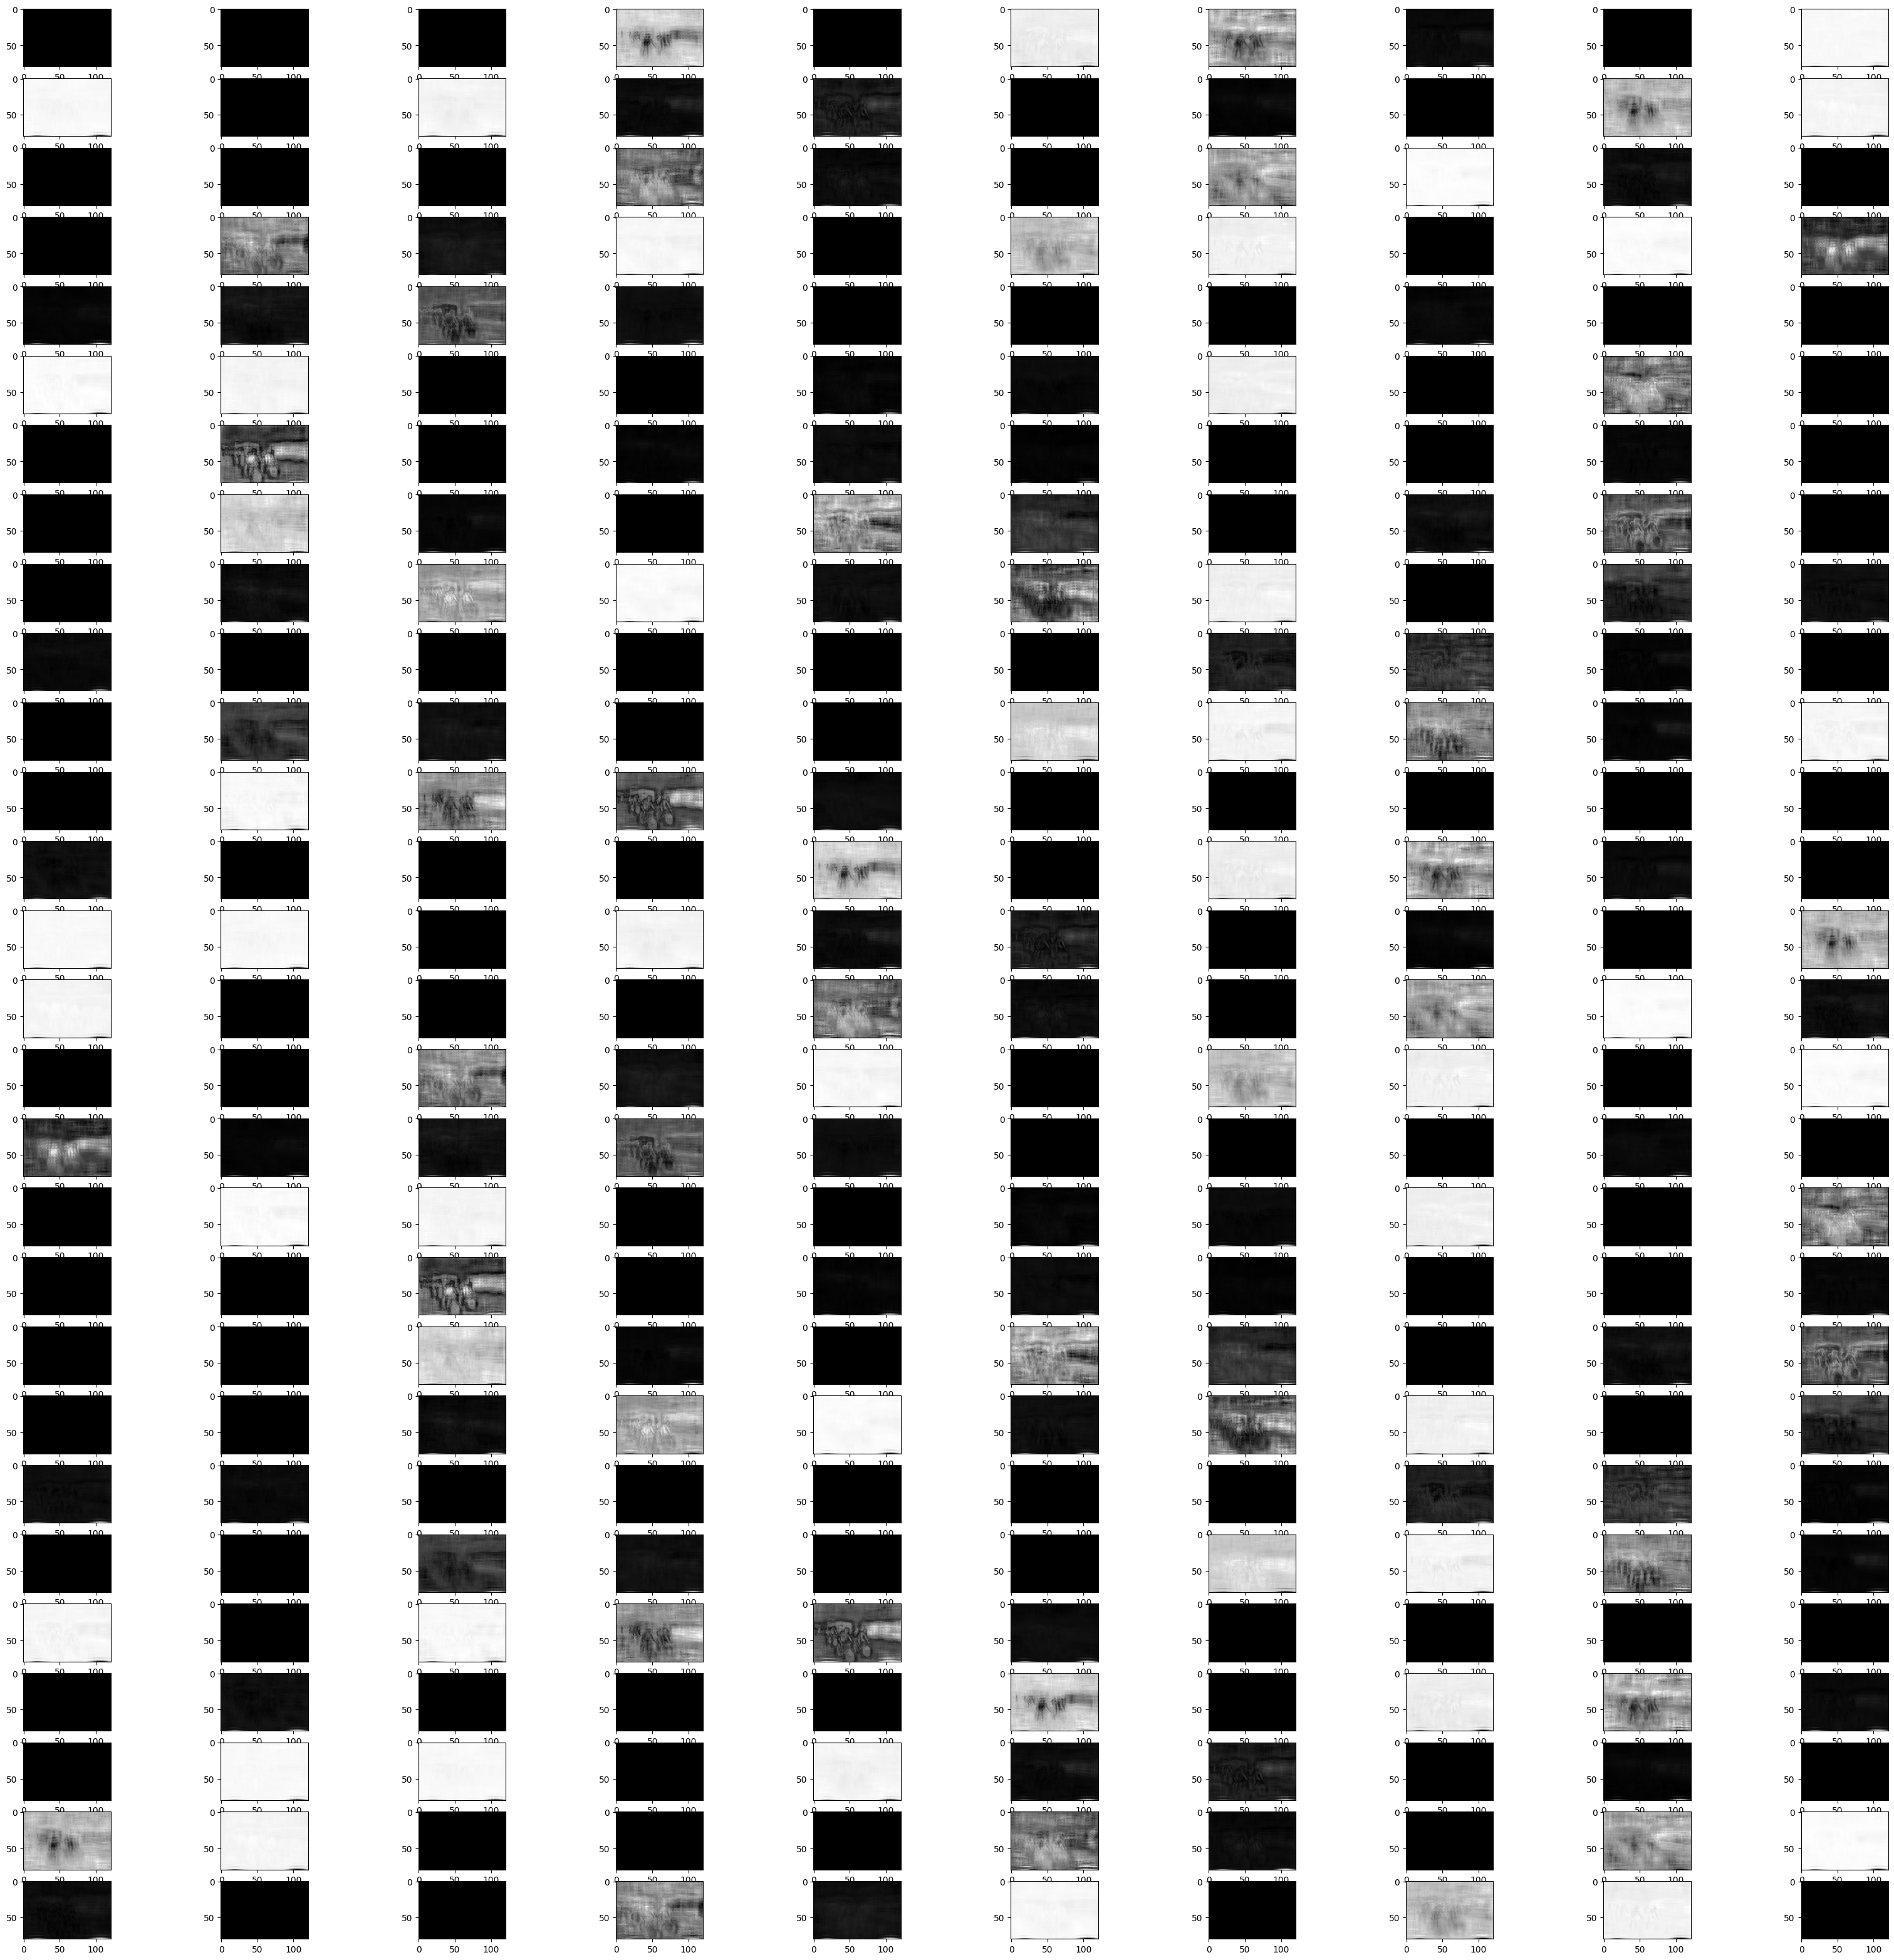

In [23]:
idx_maps = torch.log10(gradcam_attr_false_dettached[0:1, :, :, :][0].abs().max(dim=0).values)

condition = idx_maps > threshold
indices = torch.nonzero(condition).squeeze()

plt.figure(figsize=[40,40])
for i in range(280):
  plt.subplot(28,10, i + 1)
  data = np.transpose(gradcam_attr_false_dettached[0, indices[i]].numpy(), (1, 2, 0))
  _ = plt.imshow(data[:,:,1], cmap='gray')

In [24]:
# TODO: redo max logic, take max of each channel
gradcam_attr_false_dettached[0:1, :, :, :][0].abs().max(dim=2).values.max(dim=1).values[9]

tensor(6.4970e-05)

In [ ]:
gradcam_attr = layer_gradcam.attribute(normalized_inp, 
                                  target=19, 
                                  attr_dim_summation=True).detach().cpu()